# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import yaml
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import colors

chdir = False
if not chdir:
    os.chdir("./../")
    chdir = True

from src import frame_ops, plot
from src.video import Video
from src import extraction

## Loading Config File

In [2]:
with open("./configs.yaml", "r") as file:
    configs = yaml.safe_load(file)

# Creating Video Data

In [3]:
video_config_sample = 5
video_configs = configs["videos"][video_config_sample]

print (video_configs)

video = Video(**video_configs)
video.download(force=False)
_ = video.to_frames()

frames = video.sample(frequency = configs["frequency"])

{'output_folder': 'abertura-rjtv-2', 'url': 'https://www.youtube.com/watch?v=nLsbwBWM0R4', 'resolution': '144p'}


## Sampling video frame

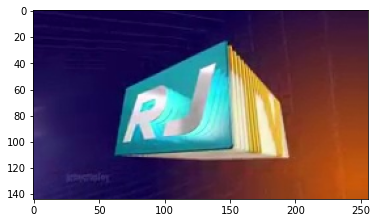

In [4]:
sample_index = -1
frame = frames[sample_index]
plt.imshow(frame)

# Smooth

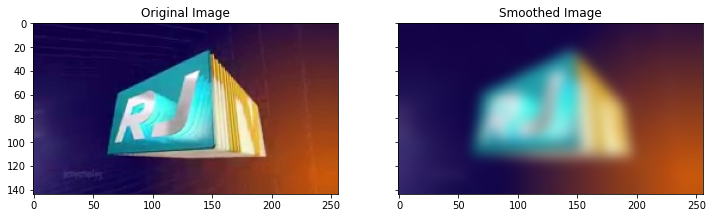

In [6]:
def plot_smoothing(frame: np.ndarray, smooth: dict, filename: str):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

    ax = axes[0]
    ax.imshow(frame)
    ax.set_title("Original Image")

    ax = axes[1]
    frame  = frame_ops.smooth(
        frame,
        **smooth
    )
    ax.imshow(frame)
    ax.set_title("Smoothed Image")
    fig.savefig(f"./notebooks/plots/{filename}", bbox_inches="tight")

plot_smoothing(frame, {'method': 'GaussianBlur', 'kernel_size': 31}, "smoothed-rjtv-2.jpg")

Smooth example with a noisy image

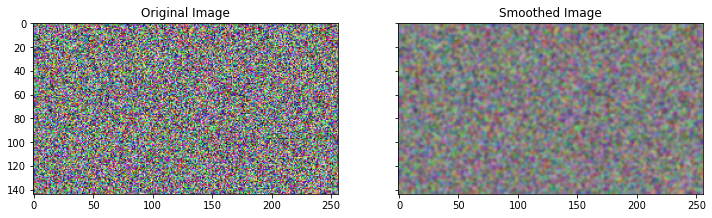

In [7]:
noise = np.random.random(frame.shape)
plot_smoothing(noise, {'method': 'GaussianBlur', 'kernel_size': 5}, "smoothed-noise.jpg")

In [8]:
smooth = {'method': 'GaussianBlur', 'kernel_size': 31}
frame_smoothed  = frame_ops.smooth(frame, **smooth)

RGB intensities distribution

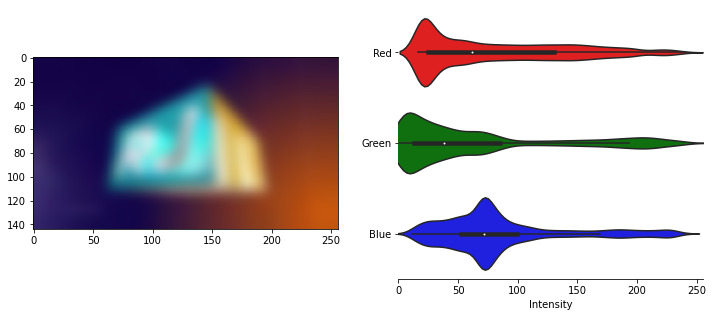

In [254]:
def plot_rgb_distribution(frame, filename: str, columns = ["Red", "Green", "Blue"], figsize = (12, 5)):
    fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=figsize)

    df_frame = pd.DataFrame(frame.reshape((frame.shape[0] * frame.shape[1], 3)), columns=columns)
    df_plot = (
        df_frame
        .melt(value_vars=columns)
        .rename({"value": "Intensity", "variable": "color"}, axis=1)
    )

    axes[0].imshow(frame)

    sns.violinplot(
        data=df_plot,
        y="color",
        x="Intensity",
        ax=axes[1],
        palette={color: color for color in df_frame.columns}
    )

    for spine in ["top", "right", "left"]:
        axes[1].spines[spine].set_visible(False)

    axes[1].set_ylabel(None)
    axes[1].set_xlim([0, 255])

    fig.savefig(f"./notebooks/plots/{filename}", bbox_inches="tight")


plot_rgb_distribution(frame_smoothed, "color_distribution.jpg")

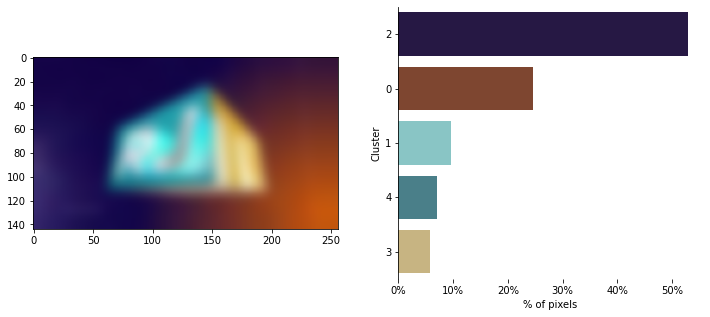

In [10]:
def plot_color_clusters(frame, cluster, filename, figsize = (12, 5)):

    fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=figsize)
    axes[0].imshow(frame)

    pixels = frame.reshape((frame.shape[0] * frame.shape[1], 3))
    model = extraction.get_extraction_model(cluster["method"], cluster["params"])
    model.fit(pixels)
    clusters = model.transform(pixels)
    centroids = model.get_centroids()

    df_plot = (
        pd.DataFrame(clusters, columns=["cluster"])
        .value_counts()
        .reset_index()
        .rename({0: "count"}, axis=1)
        .sort_values(by=["count"])
    )
    df_plot["count"] = 100 * df_plot["count"] / df_plot["count"].sum()
    cluster_order = df_plot.sort_values("count", ascending=False)["cluster"]
    palette = [
        colors.to_hex(centroids.values[i] / 255, keep_alpha=False)
        for i in cluster_order
    ]

    sns.barplot(
        data=df_plot,
        x="count",
        y="cluster",
        orient="h",
        palette=palette,
        order=cluster_order,
        ax=axes[1]
    )
    [axes[1].spines[spine].set_visible(False) for spine in ["top", "right", "bottom"]]
    axes[1].set_ylabel("Cluster"), axes[1].set_xlabel("% of pixels")
    axes[1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

    fig.savefig(f"./notebooks/plots/{filename}", bbox_inches="tight")

plot_color_clusters(frame_smoothed, {"method": "KMeans", "params": {"n_clusters": 5}}, "colors_cluster_distribution.jpg")

([], [])

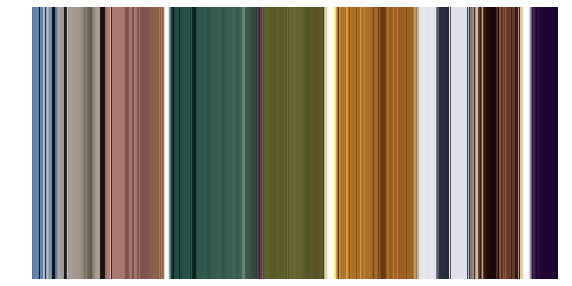